# 1. PROJE ÖDEVİ - BLG-407 MAKİNE ÖĞRENMESİ

**Adınız:** Mustafa Erdem

**Soyadınız:** Kaya

**Okul Numaranız:** 2212721009

**GitHub Repo Bağlantısı:** `https://github.com/kullanici_adi/CNN_siniflandirma`


# Model 2: Sıfırdan Basit CNN Mimarisi

Bu notebook dosyasında, herhangi bir hazır model (Transfer Learning) kullanılmadan, **sıfırdan kendi oluşturduğumuz** basit bir Evrişimli Sinir Ağı (CNN) eğitilecektir.

## Amaç

Temel bir CNN yapısının performansını gözlemlemek ve Model 1 (Transfer Learning) ile karşılaştırmak. Bu model, CIFAR-10 örneğine benzer şekilde, sıfırdan eğitilen basit bir mimari kullanır.

## Model Özellikleri

* **Mimari:** 3 adet Evrişim (Conv) bloğu ve ardından Tam Bağlantılı (Dense) katmanlar
* **Veri:** Sadece normalizasyon (rescaling) yapılmıştır, henüz veri artırma (augmentation) uygulanmamıştır (Model 3'te kullanılacak)
* **Eğitim:** Tüm katmanlar sıfırdan eğitilir, önceden eğitilmiş ağırlık kullanılmaz

## Model 1 ile Farkı

Model 1'de Transfer Learning kullanılarak önceden eğitilmiş VGG16 modelinden yararlanıldı. Model 2'de ise tamamen sıfırdan, küçük bir CNN mimarisi ile eğitim yapılmaktadır. Bu, küçük veri setlerinde genellikle daha düşük performans gösterebilir ancak modelin nasıl öğrendiğini anlamak için önemlidir.

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import os
from google.colab import drive

# Drive Bağlantısı
drive.mount('/content/drive')

# --- Temel Ayarlar ---
dataset_path = '/content/drive/MyDrive/makine öğrenmesi/ödev1/dataset'
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Veri Setinin Yüklenmesi ve Ön İşleme

Model 2 aşamasında **Veri Artırma (Data Augmentation)** tekniği kullanılmamaktadır (Bu teknik Model 3'te kullanılacaktır).

## Veri Ön İşleme:

* **Normalizasyon:** Veriler sadece 0-1 aralığına normalize edilerek modele verilir (`rescale=1./255`)
* **Veri Bölünmesi:** Veri seti %80 Eğitim, %20 Doğrulama olarak bölünür
* **Boyutlandırma:** Tüm görseller 128x128 piksel boyutuna getirilir
* **Batch İşleme:** Her seferinde 32 görsel işlenir

**Önemli:** Model 2'de veri artırma yapılmadığı için, model daha az çeşitlilik görecek ve bu durum performansı etkileyebilir.

In [ ]:
# Veri ön işleme için ImageDataGenerator oluşturuluyor (Sadece normalizasyon)
datagen = ImageDataGenerator(
    rescale=1./255,          # Piksel değerlerini 0-1 aralığına normalize et
    validation_split=0.2     # Veri setinin %20'sini doğrulama için ayır
)

print("Eğitim verileri yükleniyor...")
# Eğitim verileri için generator oluşturuluyor
train_generator = datagen.flow_from_directory(
    dataset_path,                    # Veri setinin bulunduğu klasör
    target_size=(IMG_HEIGHT, IMG_WIDTH),  # Tüm görselleri 128x128 boyutuna getir
    batch_size=BATCH_SIZE,           # Her seferinde 32 görsel işle
    class_mode='binary',             # İkili sınıflandırma modu
    subset='training'                # Eğitim alt kümesini kullan (%80)
)

print("Doğrulama verileri yükleniyor...")
# Doğrulama verileri için generator oluşturuluyor
val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'             # Doğrulama alt kümesini kullan (%20)
)

print(f"Algılanan sınıflar: {train_generator.class_indices}")

Eğitim verileri yükleniyor...
Found 160 images belonging to 2 classes.
Doğrulama verileri yükleniyor...
Found 40 images belonging to 2 classes.
Algılanan sınıflar: {'Kesici_Delici': 0, 'Taşıyıcı_Servis': 1}


# CNN Mimarisi Tanımlama

Bu bölümde, sıfırdan eğitilecek basit bir CNN mimarisi tanımlanmaktadır. Bu mimari, CIFAR-10 örneğine benzer şekilde tasarlanmıştır.

## Mimari Yapısı:

Klasik ve sade bir mimari oluşturulmuştur:

1. **Conv2D + ReLU:** Özellik çıkarma (Kenar, köşe, doku tespiti). Her katmanda daha karmaşık özellikler öğrenilir.
2. **MaxPooling2D:** Boyut azaltma ve önemli özellikleri belirginleştirme. Ayrıca hesaplama maliyetini düşürür.
3. **Flatten:** Çok boyutlu özellik haritasını tek boyutlu vektöre dönüştürür.
4. **Dense:** Tam bağlantılı katmanlar ile sınıflandırma yapılır.

## Katman Detayları:

* **1. Blok:** 32 filtre, 3x3 kernel - Temel özellikleri öğrenir
* **2. Blok:** 64 filtre, 3x3 kernel - Orta seviye özellikleri öğrenir
* **3. Blok:** 64 filtre, 3x3 kernel - Yüksek seviye özellikleri öğrenir
* **Sınıflandırma Bloğu:** 64 nöronlu Dense katman + Sigmoid çıkış

**Toplam 3 adet evrişim bloğu** kullanılmıştır. Bu, küçük veri setleri için uygun bir mimaridir.

In [ ]:
# Basit CNN modelini oluştur
model = models.Sequential([
    # 1. Evrişim Bloğu: 32 filtre ile temel özellikleri öğren
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.MaxPooling2D((2, 2)),  # Boyutu yarıya indir (128x128 -> 64x64)

    # 2. Evrişim Bloğu: 64 filtre ile orta seviye özellikleri öğren
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),  # Boyutu yarıya indir (64x64 -> 32x32)

    # 3. Evrişim Bloğu: 64 filtre ile yüksek seviye özellikleri öğren
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),  # Boyutu yarıya indir (32x32 -> 16x16)

    # Sınıflandırma Bloğu
    layers.Flatten(),              # Çok boyutlu veriyi düzleştir
    layers.Dense(64, activation='relu'),  # 64 nöronlu gizli katman
    layers.Dense(1, activation='sigmoid')  # Çıkış katmanı (ikili sınıflandırma)
])

# Modeli derle: Adam optimizer ve binary crossentropy loss ile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()  # Model mimarisini görüntüle

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       802,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 859,265 (3.28 MB)

 Trainable params: 859,265 (3.28 MB)

 Non-trainable params: 0 (0.00 B)

# Modelin Eğitimi

Bu aşamada model sıfırdan eğitilmeye başlanır. Transfer Learning kullanılmadığı için, tüm katmanlar sıfırdan öğrenecektir.

## Eğitim Parametreleri:

* **`epochs=15`**: Modelin tüm eğitim veri setinin üzerinden 15 kez geçeceğini belirtir. Sıfırdan eğitim için genellikle daha fazla epoch gerekir.

* **`model.fit()`**: Eğitimi başlatan asıl fonksiyondur. Model bu aşamada verilerle ağırlıklarını günceller.

* **`train_generator`**: Modelin öğrenmek için kullanacağı eğitim verilerini sağlayan kaynaktır. Görselleri batch'ler halinde (32'şer) yükler.

* **`validation_data=val_generator`**: Her bir epoch bittiğinde, modelin hiç görmediği bu doğrulama verileriyle test edilmesini sağlar.

## ModelCheckpoint Kullanımı

Eğitim sırasında, her epoch'ta validation loss'u kontrol ederek en iyi performans gösteren model ağırlıklarını otomatik olarak kaydediyoruz. Bu sayede:
- Eğitim sırasında overfitting olsa bile en iyi modeli koruyoruz
- Model performansı düşse bile en iyi checkpoint'i geri yükleyebiliyoruz

**Not**: Eğitim sırasında `history` objesi, her epoch için accuracy ve loss değerlerini saklar. Bu değerler daha sonra grafik çizmek için kullanılacaktır.

In [ ]:
# ModelCheckpoint: En iyi ağırlıkları kaydet
checkpointer = ModelCheckpoint(
    filepath='model2_best_weights.weights.h5',
    monitor='val_loss',              # Validation loss'u izle
    verbose=1,                       # Kayıt işlemini göster
    save_best_only=True,            # Sadece en iyi modeli kaydet
    save_weights_only=True          # Sadece ağırlıkları kaydet (model yapısı değil)
)

print("Eğitim başlıyor (Basit CNN - Sıfırdan Eğitim)...")
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator,
    callbacks=[checkpointer],       # En iyi ağırlıkları kaydetmek için callback
    verbose=1
)

Eğitim başlıyor (Basit CNN - Sıfırdan Eğitim)...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5251 - loss: 0.8839
Epoch 1: val_loss improved from inf to 0.69199, saving model to model2_best_weights.weights.h5
5/5 ━━━━━━━━━━━━━━━━━━━━ 25s 4s/step - accuracy: 0.5188 - loss: 0.8789 - val_accuracy: 0.5000 - val_loss: 0.6920
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.4869 - loss: 0.6956
Epoch 2: val_loss did not improve from 0.69199
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.4911 - loss: 0.6954 - val_accuracy: 0.5000 - val_loss: 0.6923
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.4351 - loss: 0.6959 
Epoch 3: val_loss improved from 0.69199 to 0.69171, saving model to model2_best_weights.weights.h5
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 0.4365 - loss: 0.6963 - val_accuracy: 0.6500 - val_loss: 0.6917
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.6435 - loss: 0.6882
Epoch 4: val_loss improved from 0.69171 to 0.68452, saving model to model2_best_weig

# Eğitim ve Doğrulama Grafikleri

Aşağıdaki grafikler, modelin eğitim sürecindeki performansını görselleştirir. Bu grafikler sayesinde:

1. **Modelin öğrenme durumunu** takip edebiliriz
2. **Overfitting** (ezberleme) olup olmadığını anlayabiliriz
3. **Epoch sayısının yeterli** olup olmadığını değerlendirebiliriz

## Grafik Yorumlama:

* **İdeal Durum**: Eğitim ve doğrulama eğrileri birbirine yakın ve artış gösteriyorsa model iyi öğreniyor demektir.
* **Overfitting Belirtisi**: Eğitim accuracy'si yüksek ama doğrulama accuracy'si düşükse, model ezberliyor demektir. Bu durumda model eğitim verilerini ezberlemiş ama genelleme yapamıyor demektir.
* **Underfitting Belirtisi**: Her iki eğri de düşük seviyede kalıyorsa, model yeterince öğrenemiyor demektir. Bu durumda model mimarisi veya epoch sayısı yetersiz olabilir.

**Önemli:** Model 2'de veri artırma kullanılmadığı için, Model 1'e göre daha fazla overfitting görülebilir.

# En İyi Model Ağırlıklarının Yüklenmesi

Eğitim sırasında kaydedilen en iyi performans gösteren model ağırlıklarını yüklüyoruz. Bu, eğitim sırasında overfitting olsa bile en optimal modeli kullanmamızı sağlar.


In [ ]:
# En iyi ağırlıkları yükle
if os.path.exists('model2_best_weights.weights.h5'):
    model.load_weights('model2_best_weights.weights.h5')
    print("✅ En iyi model ağırlıkları yüklendi!")
else:
    print("⚠️  Model ağırlık dosyası bulunamadı. Son eğitilmiş ağırlıklar kullanılıyor.")


✅ En iyi model ağırlıkları yüklendi!


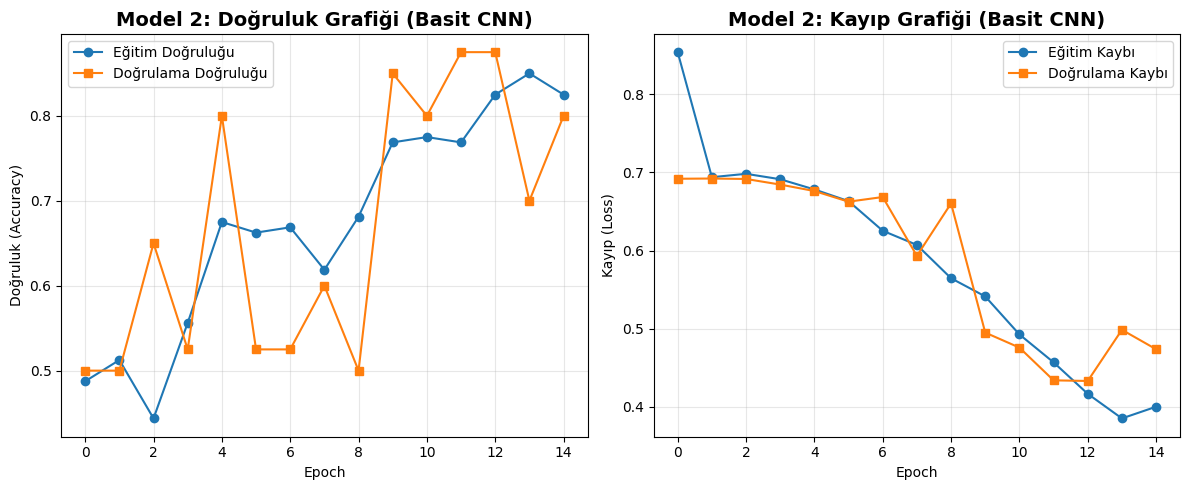


Model 2 (Basit CNN - Sıfırdan Eğitim) Test Sonuçları:
Test Doğruluğu (Accuracy): %87.50
Test Kaybı (Loss): 0.4330


In [ ]:
# Grafik boyutunu ayarla
plt.figure(figsize=(12, 5))

# Doğruluk (Accuracy) Grafiği
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu', marker='o')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu', marker='s')
plt.title('Model 2: Doğruluk Grafiği (Basit CNN)', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk (Accuracy)')
plt.legend()
plt.grid(True, alpha=0.3)

# Kayıp (Loss) Grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı', marker='o')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı', marker='s')
plt.title('Model 2: Kayıp Grafiği (Basit CNN)', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Kayıp (Loss)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Grafik Yorumu:
# - Eğitim ve doğrulama eğrileri birbirine yakınsa model genelleme yapıyor demektir
# - Doğrulama accuracy'si eğitim accuracy'sinden çok düşükse overfitting var demektir
# - Loss değerleri azalıyorsa model öğreniyor demektir

# --- NİHAİ TEST SONUCU ---
print("\n" + "="*50)
print("Model 2 (Basit CNN - Sıfırdan Eğitim) Test Sonuçları:")
print("="*50)
loss, accuracy = model.evaluate(val_generator, verbose=0)
print(f"Test Doğruluğu (Accuracy): %{accuracy*100:.2f}")
print(f"Test Kaybı (Loss): {loss:.4f}")
print("="*50)

